# Handwritten Digit Recognition with CNN
## Kevin Veeder

This project uses a Convolutional Neural Network (CNN) to classify handwritten digits from the popular MNIST dataset for a kaggle competition.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, LeakyReLU
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"train.shape = {train.shape}")
print(f"test.shape = {test.shape}")
train.head(5)

train.shape = (42000, 785)
test.shape = (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y = train['label']
X = train.drop('label', axis=1)

### Data Preprocessing

- **Normalization**: I apply grayscale normalization to minimize the impact of lighting variations across images. This not only helps the model focus on meaningful patterns rather than brightness differences, but also speeds up the training process.

- **Reshape**: The training and testing images have a shape of 28x28. All the data is reshaped into 3D matrices of size 28x28x1 because Keras requires an additional dimension at the end to represent the number of channels. Since the images are grayscale, there is only one channel.

- **Label Encoding**: encode labels to one hot vectors.
    - for example:
        - 1 => ***[0 1 0 0 0 0 0 0 0 0]***
        - 4 => ***[0 0 0 0 1 0 0 0 0 0]***

In [4]:
# Normalization
print('Before Normalization:')
print(f"Train Min: {X.min().min()}, Train Max: {X.max().max()}")
print(f"Test Min: {test.min().min()}, Test Max: {test.max().max()}")

X = X / 255.0
test = test / 255.0
print('After Normalization:')
print(f"Train Min: {X.min().min()}, Train Max: {X.max().max()}")
print(f"Test Min: {test.min().min()}, Test Max: {test.max().max()}")

Before Normalization:
Train Min: 0, Train Max: 255
Test Min: 0, Test Max: 255
After Normalization:
Train Min: 0.0, Train Max: 1.0
Test Min: 0.0, Test Max: 1.0


In [5]:
# Reshaping
X = X.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

print(f"X shape: {X.shape}")
print(f"Test shape: {test.shape}")

X shape: (42000, 28, 28, 1)
Test shape: (28000, 28, 28, 1)


In [6]:
# Label Encoding
print(f"Before the label encoding: \n y[0]={y[0]} \n y[1]={y[1]}")
y = to_categorical(y, num_classes = 10)
print(f"After the label encoding: \n y[0] = class '1' = {y[0]} \n y[1] = class '0' = {y[1]}")

Before the label encoding: 
 y[0]=1 
 y[1]=0
After the label encoding: 
 y[0] = class '1' = [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 
 y[1] = class '0' = [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Split the Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f" X_train shape: {X_train.shape} \n X_test shape: {X_test.shape} \n y_train shape: {y_train.shape} \n y_test shape: {y_test.shape}")

 X_train shape: (33600, 28, 28, 1) 
 X_test shape: (8400, 28, 28, 1) 
 y_train shape: (33600, 10) 
 y_test shape: (8400, 10)


## Convulutional Neural Network

Convolutional Neural Networks—aka CNNs—are powerful tools for working with images. They’re commonly used for things like image classification and object detection.

The key idea behind a CNN is to scan an image for patterns (like edges, textures, or shapes) using small filters, kind of like using a magnifying glass to pick out important details while shrinking the overall image size so it’s easier and faster to process.

   1. *Starting with the Image and Filters*
        - Imagine you’ve got an image and you’re trying to find specific visual features in it. That’s where filters (also called kernels) come in.
        - These filters are tiny grids (like 3x3 or 5x5) that move over the image, helping the network detect patterns like edges, corners, or textures.
        

   2. *How the Filter Works*
        - The filter slides across the image—this movement is called the stride.
        - At each step, it multiplies the overlapping values between the image and the filter, adds them up, and spits out a single number.
        - That number tells us how strongly the feature shows up at that spot.
        
    
   3. *Creating Feature Maps*
        - Once the filter has scanned the whole image, we get a feature map—a kind of heatmap showing where that feature appears.
        - If we use multiple filters, we get multiple feature maps, each focusing on a different kind of detail in the image.
        

   4. *Why the Image Gets Smaller*
        - Every time we apply a convolution, the image size gets smaller. That’s helpful for speeding things up, but it means we lose some information too.
        - To make the model more flexible and handle real-world complexity, we add a ReLU activation after the convolution. This introduces non-linearity, which is important because real images aren’t just made of straight lines.
        
### Key Building Blocks in CNNs
    
#### Same Padding
   - When we keep applying convolutions, the image can shrink too fast. To keep early layers from losing too much detail, we use same padding.
   - It keeps the output the same size as the input by adding zeros around the edges.
    
#### Max Pooling
   - Max pooling helps reduce the size of our feature maps while keeping the most important information.
   - It also helps the model recognize features no matter their size or rotation, and cuts down the number of parameters (which helps prevent overfitting).
    
#### Flattening
   - Flattening is exactly what it sounds like—it takes the multi-dimensional data from the convolutional layers and turns it into a 1D vector.
   - This step gets the data ready for the final decision-making layers.

#### Fully Connected Layers
   - Once the data is flattened, it flows into one or more fully connected layers, where every neuron is connected to the previous layer’s outputs.
   - This part acts like a traditional neural network and is responsible for making the final predictions—like deciding if an image contains a cat or a dog.
    
### Implementing with Keras


In [ ]:
# model creation
model = Sequential([
    # 1st convolutional layer
    Conv2D(filters=32, kernel_size = (3,3), padding='Same', input_shape=(28, 28, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPool2D(pool_size=(2,2)),
    # dropout randomly selects nodes to be dropped out with a given probability in each weight update cycle
    Dropout(0.3), 
    
    # 2nd convolutional layer
    Conv2D(64, (3,3), padding='Same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.4),
    
    # 3rd convolutional layer
    Conv2D(128, (3, 3), padding='Same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    # Flatten and fully connected layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(10, activation='softmax')
])

# Model Summary
model.summary()

C:\Users\kevve\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\kevve\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 391,306 (1.49 MB)

 Trainable params: 390,858 (1.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# Define the optimizer
optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

### Compile the model

We'll be using categorical crossentropy as our loss function, which tells us we're dealing with a multi-class classification problem—in other words, the model is predicting one label out of several possible categories.

In [10]:
# Compile
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

#### Epochs and Batch Size

Let’s say you have a small dataset with 10 samples. If you set the batch size to 2, that means the model will look at 2 samples at a time before updating its weights. So, for one full pass through the data (one epoch), you’ll end up with 5 batches (because 10 ÷ 2 = 5).

Now, if you train the model for 3 epochs, that means the entire dataset will be passed through the model 3 times—so you’ll have 5 iterations per epoch, or 15 iterations total during training.

In [11]:
epochs = 100
batch_size = 250

#### Data Augmentation
To help prevent overfitting, we need to artificially expand our training dataset—especially when working with something like handwritten digits.

The idea is to apply small, random transformations to the training images so the model learns to handle real-world variations. 

For example:
- The digit might not be perfectly centered
- It could appear in different sizes (some people write big, some small)
- The image might be slightly rotated or tilted

By simulating these kinds of changes, we help the model generalize better and make it more robust when it sees new, unseen data.

In [12]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center = False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False,  # dimesion reduction
    rotation_range=5,  # randomly rotate images in the range 5 degrees
    zoom_range = 0.1, # Randomly zoom image 10%
    width_shift_range=0.1,  # randomly shift images horizontally 10%
    height_shift_range=0.1,  # randomly shift images vertically 10%
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False  # randomly flip images    
)

datagen.fit(X_train)

Note: (below) cell takes a while to run...

In [13]:
# NOTE: takes about ___ minutes to run
%timeit
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Save the best model based on validation loss
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Fit the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, y_test),
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/100


C:\Users\kevve\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.2440 - loss: 2.4062
Epoch 1: val_loss improved from inf to 6.79769, saving model to best_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 390ms/step - accuracy: 0.2452 - loss: 2.4014 - val_accuracy: 0.1082 - val_loss: 6.7977 - learning_rate: 0.0010
Epoch 2/100
  1/134 ━━━━━━━━━━━━━━━━━━━━ 41s 312ms/step - accuracy: 0.6560 - loss: 0.9541

C:\Users\kevve\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 6.79769 to 6.75886, saving model to best_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6560 - loss: 0.9541 - val_accuracy: 0.1082 - val_loss: 6.7589 - learning_rate: 0.0010
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7361 - loss: 0.7912
Epoch 3: val_loss did not improve from 6.75886
134/134 ━━━━━━━━━━━━━━━━━━━━ 51s 376ms/step - accuracy: 0.7364 - loss: 0.7903 - val_accuracy: 0.1082 - val_loss: 7.0041 - learning_rate: 0.0010
Epoch 4/100
  1/134 ━━━━━━━━━━━━━━━━━━━━ 40s 301ms/step - accuracy: 0.8480 - loss: 0.5066
Epoch 4: val_loss did not improve from 6.75886
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8480 - loss: 0.5066 - val_accuracy: 0.1082 - val_loss: 6.9995 - learning_rate: 0.0010
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8591 - loss: 0.4372
Epoch 5: val_loss improved from 6.75886 to 1.73571, saving model to best_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 387ms/

Epoch 25/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9595 - loss: 0.1351
Epoch 25: val_loss did not improve from 0.03408
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 380ms/step - accuracy: 0.9595 - loss: 0.1351 - val_accuracy: 0.9887 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 26/100
  1/134 ━━━━━━━━━━━━━━━━━━━━ 33s 255ms/step - accuracy: 0.9680 - loss: 0.1202
Epoch 26: val_loss did not improve from 0.03408
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9680 - loss: 0.1202 - val_accuracy: 0.9890 - val_loss: 0.0347 - learning_rate: 0.0010
Epoch 27/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9630 - loss: 0.1205
Epoch 27: val_loss improved from 0.03408 to 0.03293, saving model to best_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 386ms/step - accuracy: 0.9630 - loss: 0.1205 - val_accuracy: 0.9893 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 28/100
  1/134 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - accuracy: 0.9680 - loss: 0.1146
Epoch 28: val_loss did not

Epoch 48/100
  1/134 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - accuracy: 0.9760 - loss: 0.0854
Epoch 48: val_loss improved from 0.02171 to 0.02156, saving model to best_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9760 - loss: 0.0854 - val_accuracy: 0.9917 - val_loss: 0.0216 - learning_rate: 5.0000e-04
Epoch 49/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9762 - loss: 0.0818
Epoch 49: val_loss did not improve from 0.02156
134/134 ━━━━━━━━━━━━━━━━━━━━ 51s 376ms/step - accuracy: 0.9762 - loss: 0.0818 - val_accuracy: 0.9923 - val_loss: 0.0246 - learning_rate: 5.0000e-04
Epoch 50/100
  1/134 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.9800 - loss: 0.0536
Epoch 50: val_loss did not improve from 0.02156
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9800 - loss: 0.0536 - val_accuracy: 0.9923 - val_loss: 0.0250 - learning_rate: 5.0000e-04
Epoch 51/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9733 - loss: 0.0923
Epoch 51: val_loss 

Epoch 71/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9818 - loss: 0.0621
Epoch 71: val_loss did not improve from 0.01919
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 359ms/step - accuracy: 0.9818 - loss: 0.0621 - val_accuracy: 0.9925 - val_loss: 0.0209 - learning_rate: 2.5000e-04
Epoch 72/100
  1/134 ━━━━━━━━━━━━━━━━━━━━ 36s 278ms/step - accuracy: 0.9760 - loss: 0.0824
Epoch 72: val_loss did not improve from 0.01919
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9760 - loss: 0.0824 - val_accuracy: 0.9924 - val_loss: 0.0208 - learning_rate: 2.5000e-04
Epoch 73/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9784 - loss: 0.0713
Epoch 73: val_loss did not improve from 0.01919
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 384ms/step - accuracy: 0.9784 - loss: 0.0713 - val_accuracy: 0.9926 - val_loss: 0.0200 - learning_rate: 2.5000e-04
Epoch 74/100
  1/134 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - accuracy: 0.9960 - loss: 0.0205
Epoch 74: val_loss did not improve from 0.01919
134/

### Evaluate the model

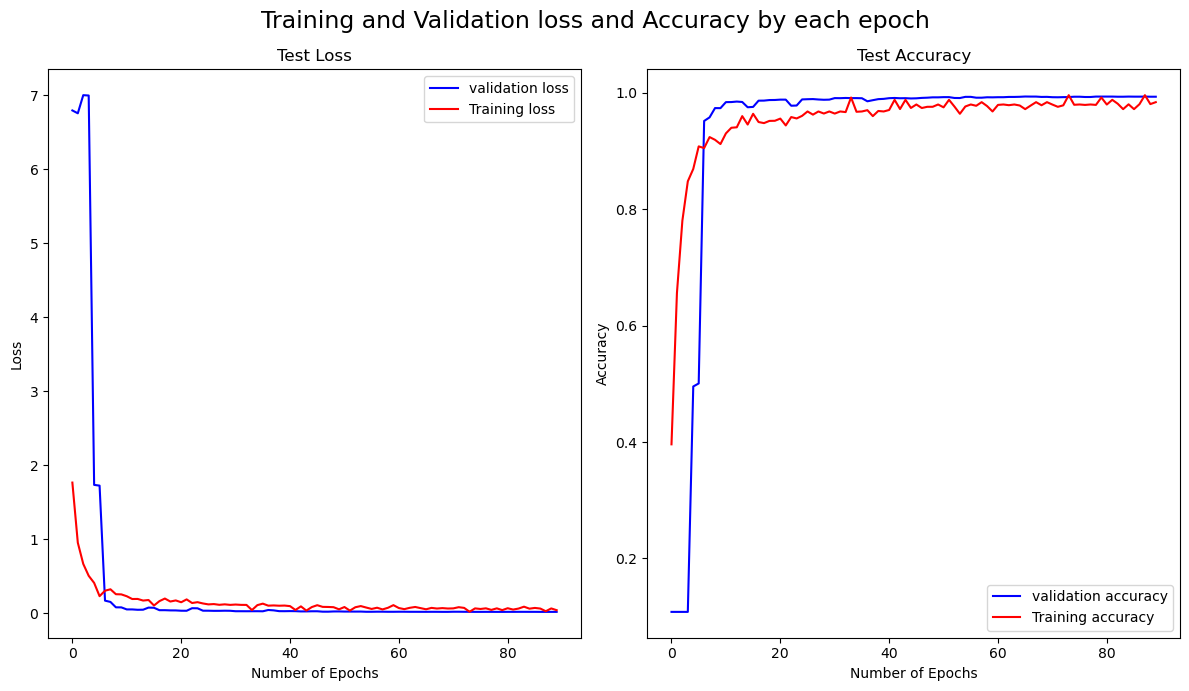

In [14]:
# Plotting training and validation loss for each epoch
plt.figure(figsize=(12,7))
plt.suptitle("Training and Validation loss and Accuracy by each epoch",fontsize=17)
plt.subplot(1,2,1)
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="Training loss")

plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(history.history['accuracy'], color='r', label="Training accuracy")

plt.title("Test Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation Summary

The model performed exceptionally well during training. As seen in the graphs:
- **Loss:** Both training and validation loss dropped rapidly in the first few epochs and stabilized near zero, indicating the model learned quickly and effectively.
- **Accuracy**: Accuracy for both training and validation reached close to 100%, showing strong generalization to unseen data.

The close alignment between training and validation curves suggests minimal overfitting, which means the model is not just memorizing the training data but is genuinely learning patterns that generalize well.


### Submit Results

In [15]:
model = load_model('best_model.keras')

In [16]:
prediction = model.predict(test)
predicted_label = np.argmax(prediction, axis=1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step


In [17]:
submission = pd.DataFrame({
    'ImageId': np.arange(1, len(predicted_label) + 1),
    'Label': predicted_label
})

submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!


In [18]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


### Kaggle Performance:
When submitted to Kaggle, this model achieved an impressive 99.375% accuracy, placing in the top 200 out of over 1,500 participants—a strong indication of its ability to generalize well to new, unseen data.